# Exploring Meta-T Tetris data from Lindstedt and Gray (2015; 2019)
-------

### Notes on data 

- Download @ https://osf.io/78ebg/
- Three files:
    - "eps" describes the games of 241 participants at the episodic level (behavioural data and scores at each zoid)
    - "gms" provides summary stats (e.g., score, zoid sequence) for each game played in "eps"
    - "quals" includes episodic and summary data for tournament qualifier games played by 44 participants
- All variables described in 2017 paper by Sibert, Lindstedt, and Gray; doi number 10.1111/tops.12225
    - 85 columns in "eps"
    - 15 columns in "gms"
    - 89 columns in "quals"

Import libraries

In [1]:
import os
import sys
import socket
import pingouin as pg
import scipy.stats as scipy

from modules import *
from hmmlearn import hmm

# initialise selected visualisation parameters
sns_styleset()
np.set_printoptions(suppress=True)

/home/ozvar/.local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Import data

In [2]:
df = pd.read_csv(os.path.join('data', 'pca_eps.csv'), header=0, sep=',', low_memory=False)

In [3]:
df.head()

,ts,event_type,SID,ECID,session,game_type,game_number,episode_number,level,score,lines_cleared,curr_zoid,next_zoid,danger_mode,rots,trans,path_length,min_rots,min_trans,min_path,min_rots_diff,min_trans_diff,min_path_diff,u_drops,s_drops,prop_u_drops,initial_lat,drop_lat,avg_lat,tetrises_game,tetrises_level,zoid_rot,zoid_col,zoid_row,all_diffs,all_ht,all_trans,cd_1,cd_2,cd_3,cd_4,cd_5,cd_6,cd_7,cd_8,cd_9,cleared,col_trans,column_9,cuml_cleared,cuml_eroded,cuml_wells,d_all_ht,d_max_ht,d_mean_ht,d_pits,deep_wells,eroded_cells,full_cells,jaggedness,landing_height,lumped_pits,matches,max_diffs,max_ht,max_ht_diff,max_well,mean_ht,mean_pit_depth,min_ht,min_ht_diff,move_score,nine_filled,pattern_div,pit_depth,pit_rows,pits,row_trans,tetris,tetris_progress,weighted_cells,wells,criterion,crit_game,study,ep_dur,resp_lat,disarray,well_prep,action_inefficiency,dec_act_latency
0,78.4979,EP_SUMM,101,NIL,2013_6_6_12-23-50,pop_assessment,1,0,0,16,0,O,S,False,0,4,4,0,4,4,0,0,0,17,2,0.8947,724,2083,416.6000,0,0,0,0,2,-2,4,4,0,-2,0,0,0,0,0,0,0,0,2,0,0,0,0,4,2,0.4000,0,0,0,4,2,0,0,4,0,2,1.6000,0,0.4000,0.0000,0,0.4000,0,0,2,0,0,0,2,0,0,6,0,6042,True,TS1,NaN,2083,-5.1342,-1.5870,-0.6442,1.6669
1,88.2783,EP_SUMM,101,NIL,2013_6_6_12-23-50,pop_assessment,1,1,0,24,0,S,O,False,1,7,8,1,3,4,0,4,4,8,10,0.4444,606,4671,505.5455,0,0,1,1,4,-2,9,10,2,-1,-3,0,0,0,0,0,0,0,4,0,0,0,3,5,2,0.5000,1,2,0,8,6,1,1,2,2,4,3.1000,2,0.9000,2.0000,0,0.9000,0,0,4,2,1,1,6,0,0,18,2,6042,True,TS1,9.7805,4671,-3.5601,0.0251,2.0612,1.9656
2,92.9668,EP_SUMM,101,NIL,2013_6_6_12-23-50,pop_assessment,1,2,0,38,0,O,J,False,0,10,10,0,4,4,0,6,6,15,4,0.7895,701,4061,369.1818,0,0,0,8,2,0,13,14,2,-1,-3,0,0,0,0,2,0,0,6,2,0,0,3,4,0,0.4000,0,2,0,12,8,0,1,4,2,4,2.7000,2,1.3000,2.0000,0,1.3000,0,0,5,2,1,1,8,0,0,24,2,6042,True,TS1,4.6885,4061,-3.6737,-0.0469,1.5389,-0.1266
3,99.3719,EP_SUMM,101,NIL,2013_6_6_12-23-50,pop_assessment,1,3,0,51,0,J,S,False,1,4,5,1,1,2,0,3,3,13,6,0.6842,902,2089,621.0000,0,0,1,2,3,0,16,14,2,-1,0,-3,0,0,0,2,0,0,6,2,0,0,3,3,0,0.3000,-1,2,0,16,8,0,0,6,2,4,2.4000,2,1.6000,0.0000,0,1.6000,0,0,6,0,0,0,8,0,0,31,2,6042,True,TS1,6.4051,2089,-3.6946,-0.0795,-0.0081,0.3828
4,106.9975,EP_SUMM,101,NIL,2013_6_6_12-23-50,pop_assessment,1,4,0,58,0,S,O,False,3,3,6,1,3,4,2,0,2,8,8,0.5000,857,6591,820.8889,0,0,1,1,6,0,20,18,4,-1,-2,-3,0,0,0,2,0,0,6,2,0,0,10,4,2,0.4000,0,4,0,20,12,3,0,3,4,6,4.0000,4,2.0000,0.0000,0,2.0000,0,0,6,0,0,0,12,0,0,51,4,6042,True,TS1,7.6256,6591,-2.5802,1.9508,2.4554,2.7202


## Hidden Markov Models

Set up parameters here
- declare number of states we expect to see
- declare factors to include in the model
- choose player and game to fit model to

In [4]:
# model
n_states = 3
factors = ['disarray', 'well_prep', 'action_inefficiency', 'dec_act_latency']
# data 
player_id = '103'
nth_game = 3
# for plot legends
factor_labels = {'disarray': 'Disarray', 
                'well_prep': 'Well preparation',
                'action_inefficiency': 'Action inefficiency',
                'dec_act_latency': 'Decision-action latency'}

Generate model from above parameters, returning transition matrix and log-likelihood

In [5]:
model, post_prob, LL = fit_HMM(df=df,
                               n_states=n_states, 
                               factors=factors,
                               factor_labels=factor_labels,
                               player_id=player_id,
                               nth_game=nth_game,
                               n_iter=1000,
                               covar_type='full')

Fitting 3 state model to game 3 of player 103
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   1.0000   0.0000   0.0000
State 2   0.0500   0.8000   0.1500
State 3   0.0000   0.0600   0.9400 

---------------------------
Component means for each state:
---------------------------

                         State 1  State 2  State 3
Disarray                  4.8032   0.1927  -2.4049
Well preparation         -1.4111   1.4551  -0.0351
Action inefficiency      -0.7751   0.4624  -0.9543
Decision-action latency  -0.4477   0.3492  -0.1930 

Log-likelihood of model is -754.59


Visualise time series of state probabilities together with component scores

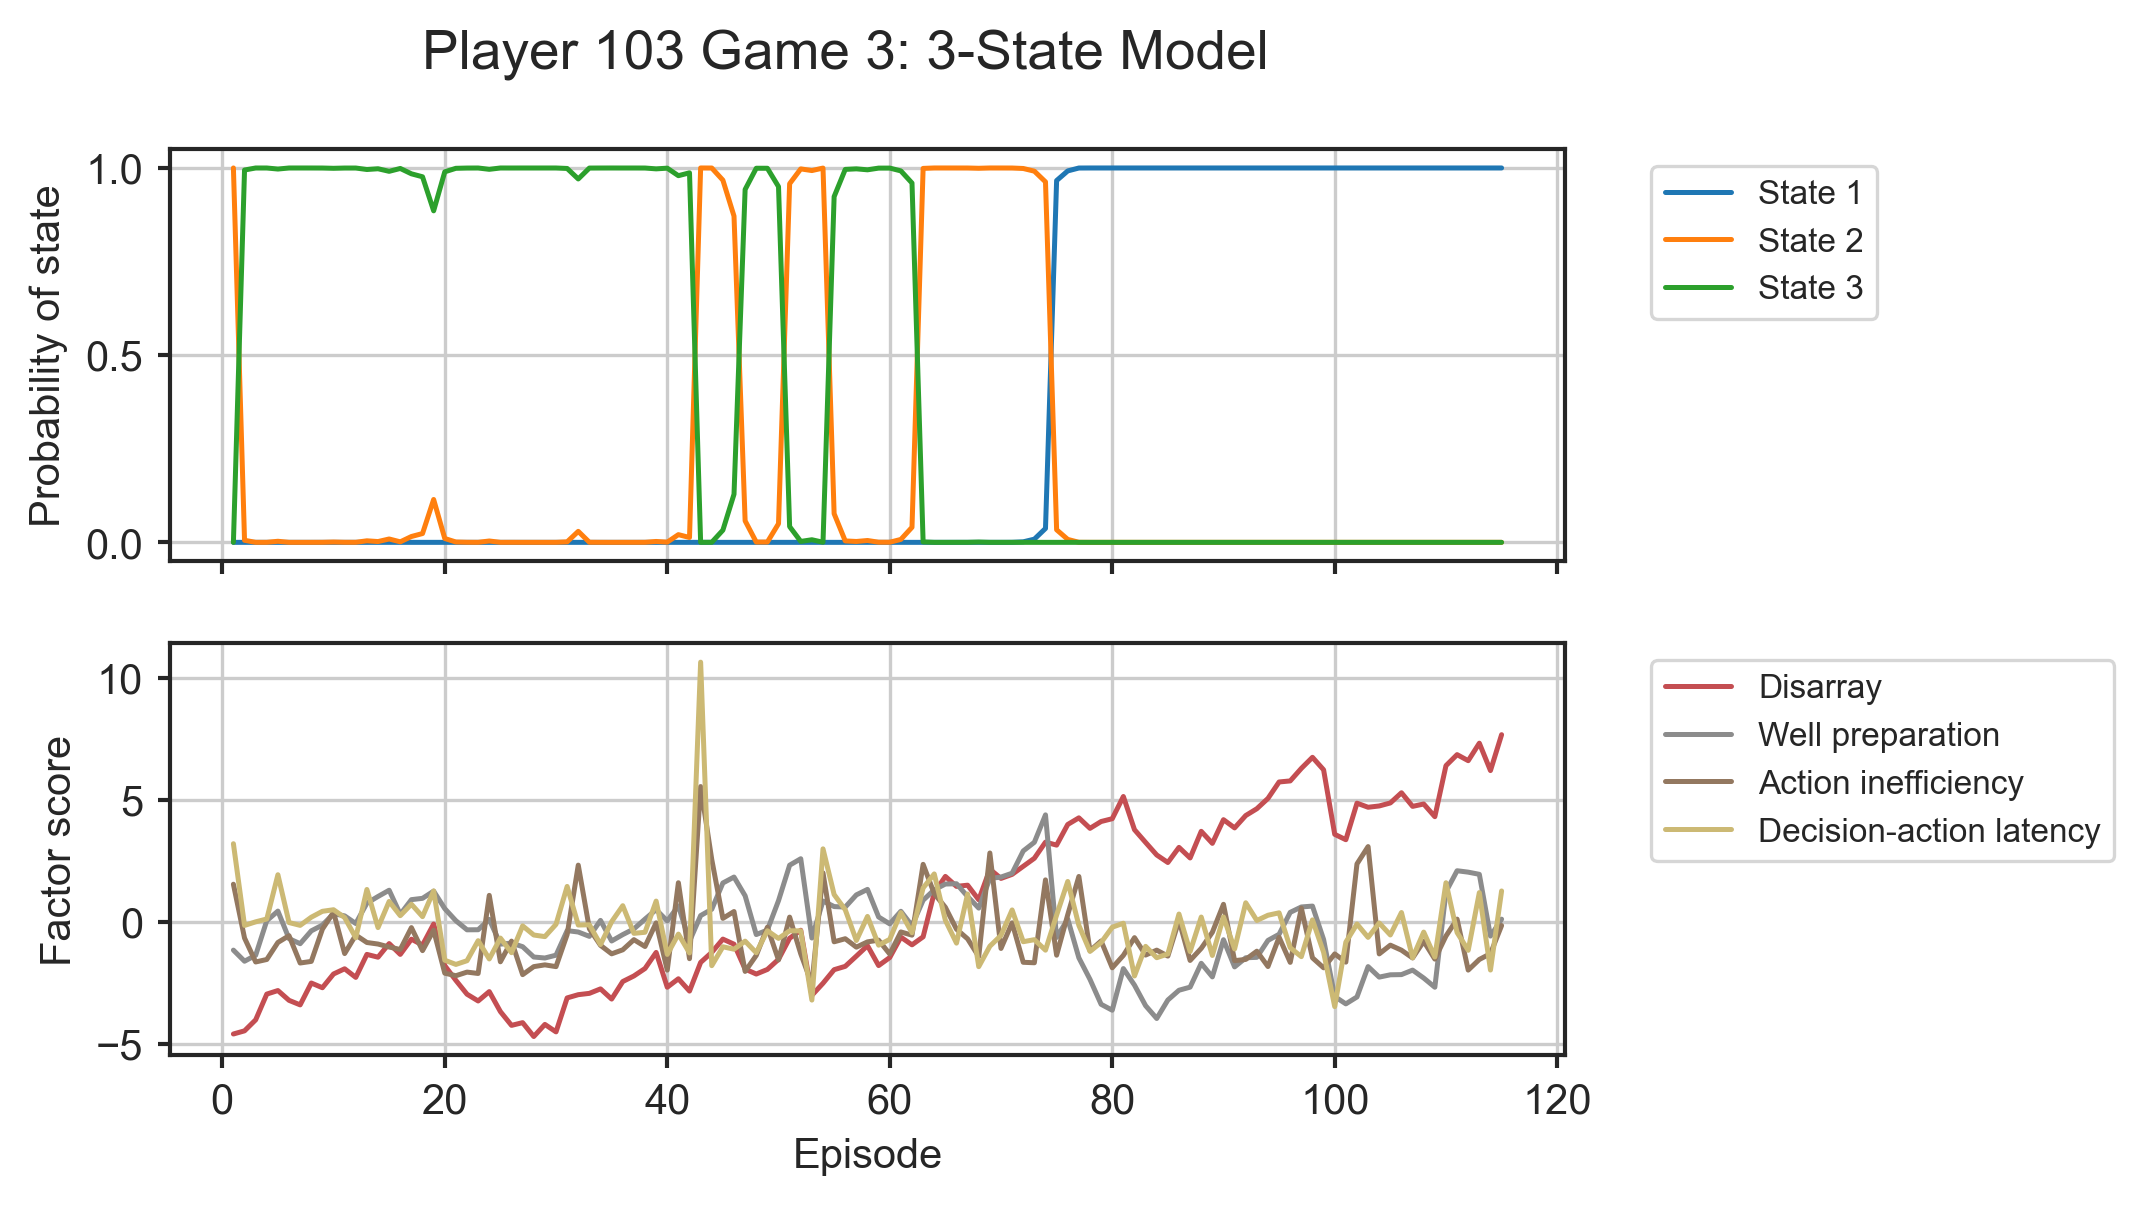

In [6]:
viz_states(df=df, 
           n_states=n_states,
           factors=factors,
           factor_labels=factor_labels,
           post_prob=post_prob,
           player_id=player_id, 
           nth_game=nth_game)

### Visualising multiple HMMs

This block first draws a subsample of tetris games played be the specified players. It then creates containers to store models for each of those games.

In [40]:
# randomly draw from our player sample
players =  ['101']
n_draw = 1
draw = np.random.choice(players, n_draw, replace=False)

# specify number of games for each player
n_games = 5

# specify number of states to iterate over
n_states = [3]

# specify factors and containers
factors = ['well_prep', 'action_inefficiency', 'dec_act_latency']

models, post_probs, LLs = [], [], []
null_models, null_probs, null_LLs = [], [], []
counter = 1

# path to save figures
fig_dir = os.path.join('figures', 'HMMs')

This block iterates over each game, fitting, saving, and visualising HMMs to each game as above, as well as a "null" model consisting of random series for each component

---
MODEL 1: Player 101 Game 1
---
Fitting 3 state model to game 1 of player 101
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.9500   0.0500   0.0000
State 2   0.0000   0.3300   0.6700
State 3   0.0700   0.0500   0.8800 

---------------------------
Component means for each state:
---------------------------

                         State 1  State 2  State 3
Well preparation         -1.6414   1.4045   2.7120
Action inefficiency       0.9794   3.8798   1.0409
Decision-action latency   0.5161  -0.3829   0.5496 

Log-likelihood of model is -626.83
---
NULL MODEL 1: Player 101 Game 1 (shuffled data)
---
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.6000   0.2900   0.1100
State 2   0.5600   0.2500   0.1900
State 3   0.6800   0.3200   0.0000 

---------------------------
Component means for each state:
-------------------------

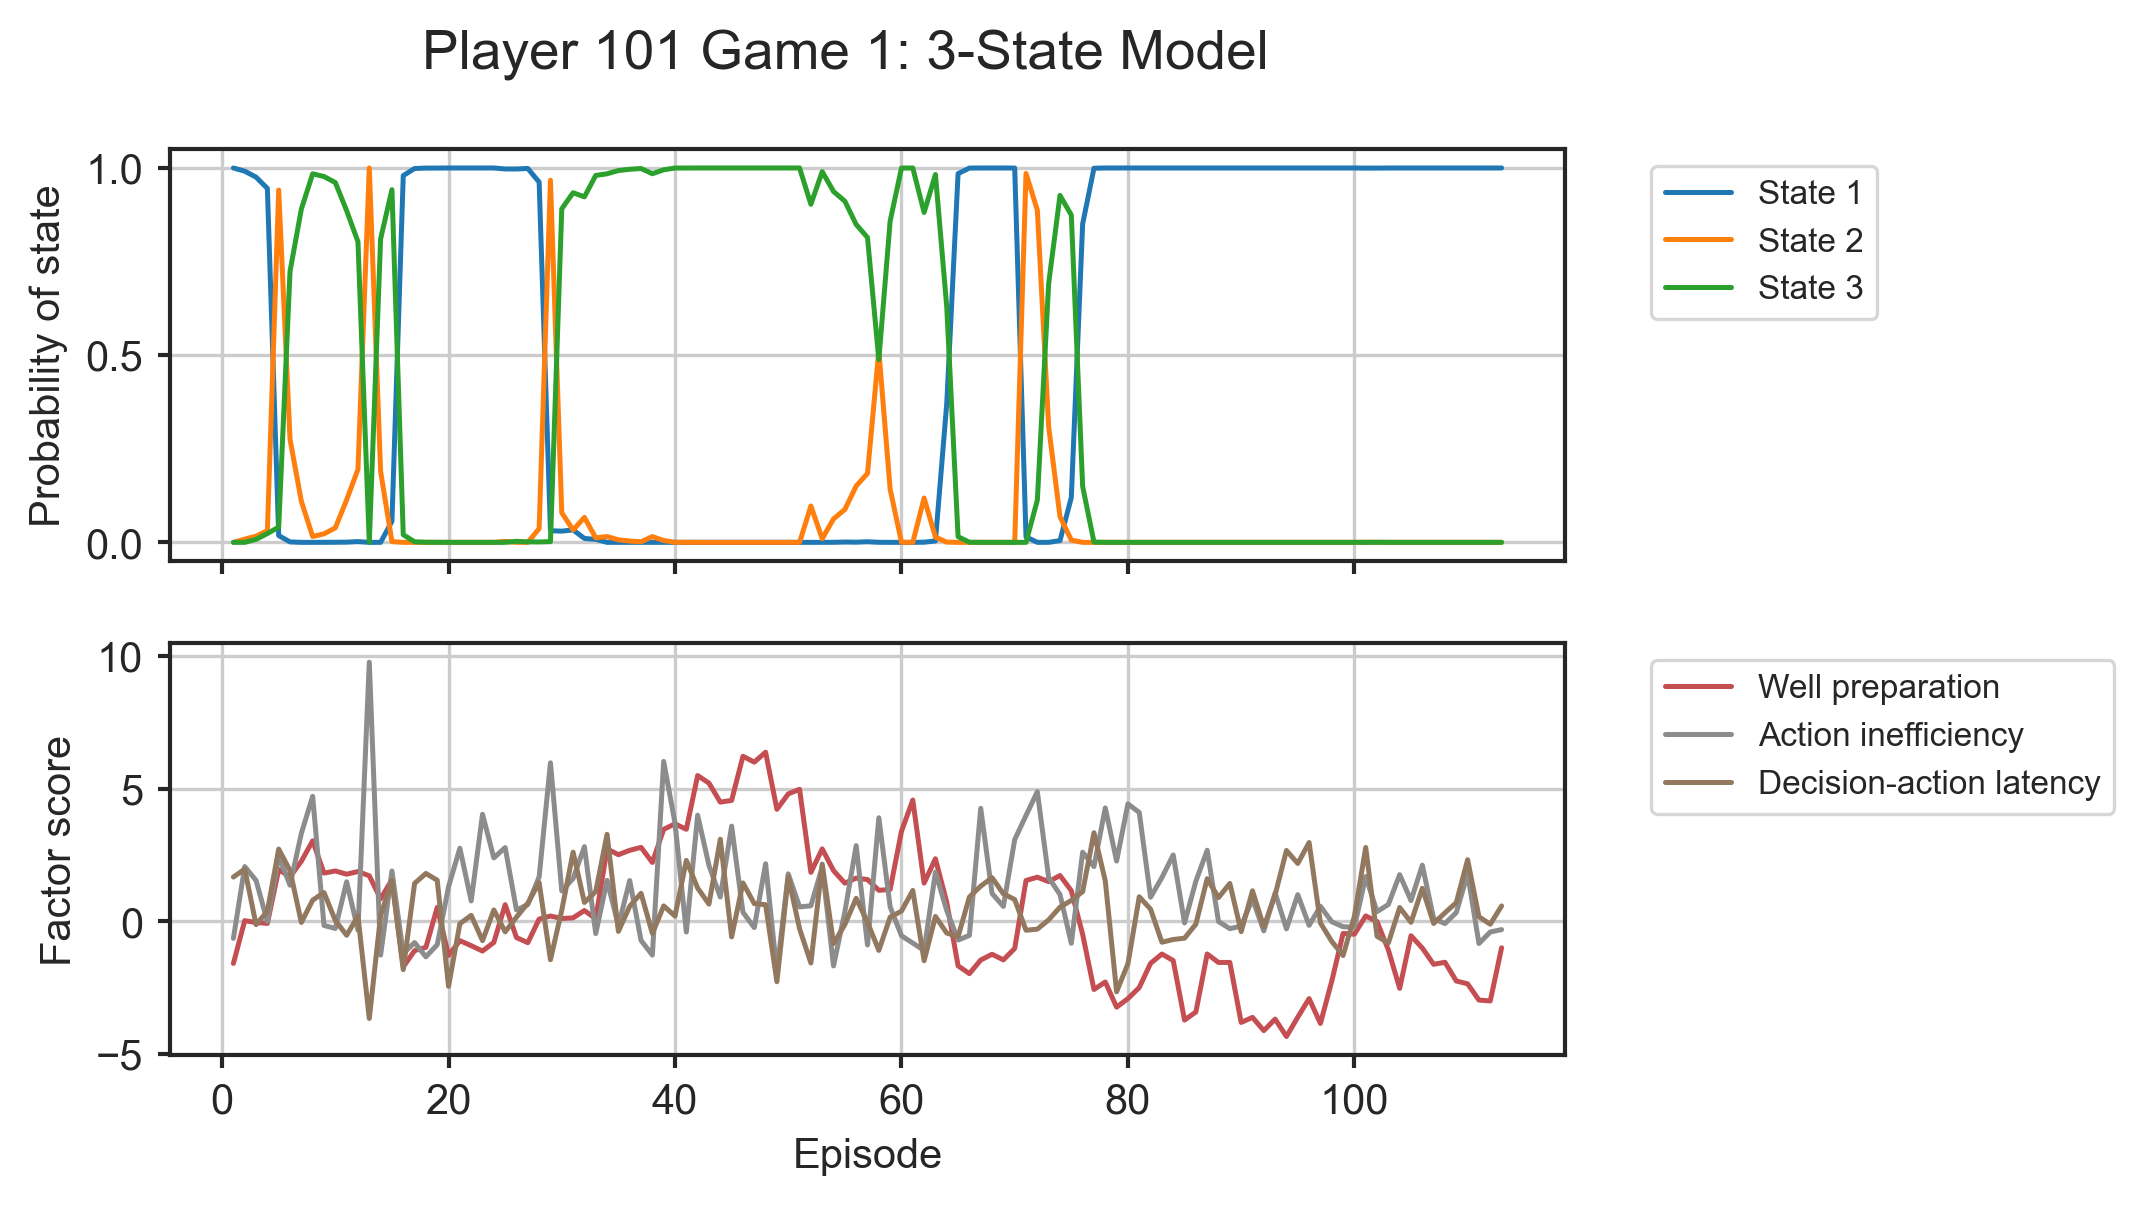

---
MODEL 2: Player 101 Game 2
---
Fitting 3 state model to game 2 of player 101
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.2400   0.7100   0.0500
State 2   0.6000   0.4000   0.0000
State 3   0.0000   0.0000   1.0000 

---------------------------
Component means for each state:
---------------------------

                         State 1  State 2  State 3
Well preparation         -1.2595  -0.7321  -3.3284
Action inefficiency      -0.2909   3.3589  -0.1632
Decision-action latency   0.7330   0.5433   1.2131 

Log-likelihood of model is -287.34
---
NULL MODEL 2: Player 101 Game 2 (shuffled data)
---
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.5700   0.2300   0.2000
State 2   0.9300   0.0000   0.0700
State 3   0.1400   0.8600   0.0000 

---------------------------
Component means for each state:
-------------------------

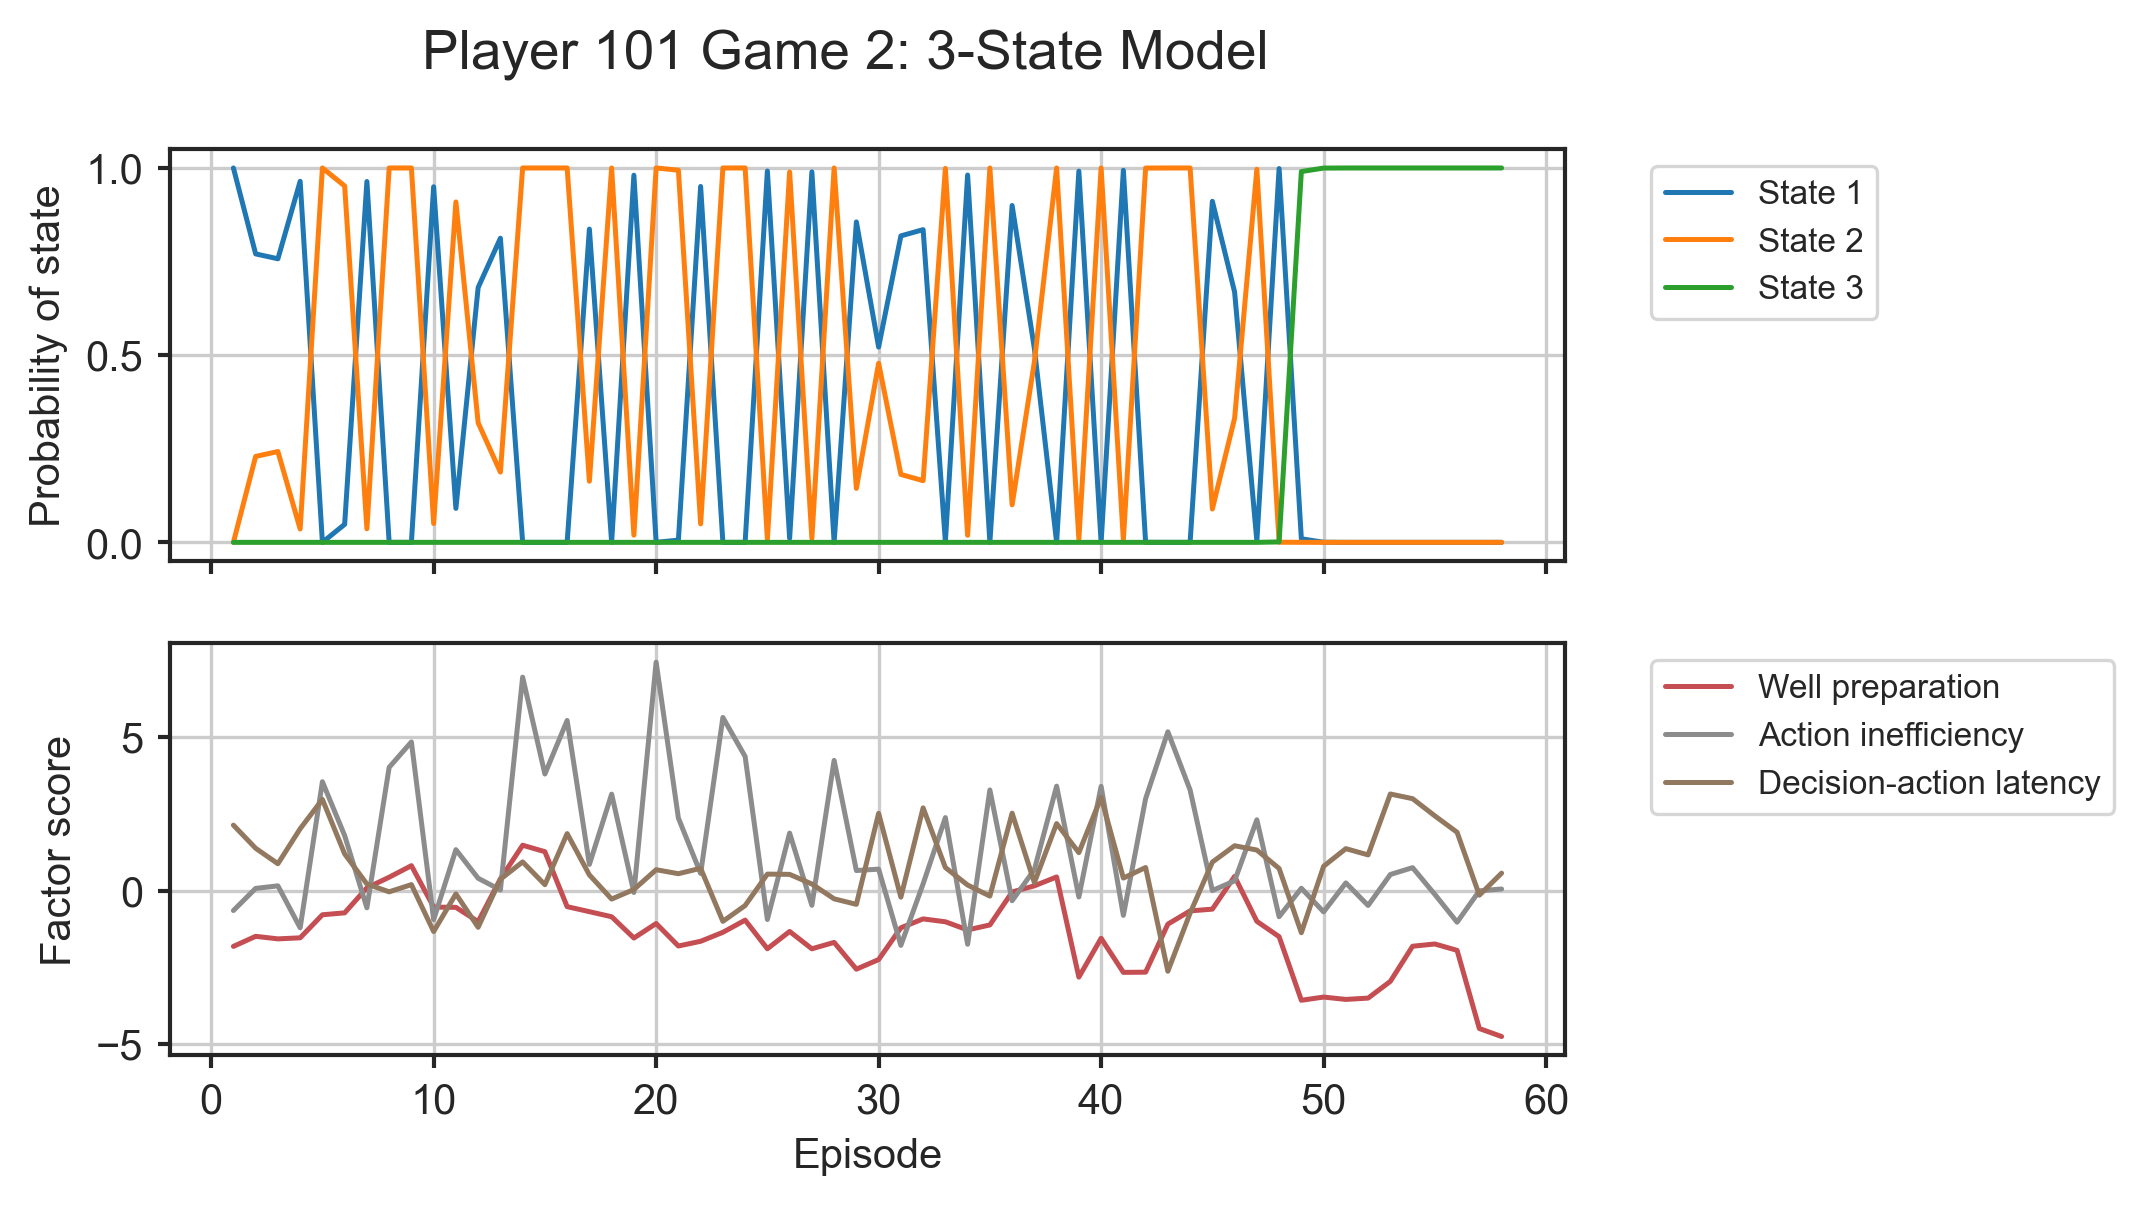

---
MODEL 3: Player 101 Game 3
---
Fitting 3 state model to game 3 of player 101
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.9400   0.0600   0.0100
State 2   0.1700   0.8300   0.0000
State 3   0.0000   0.0000   1.0000 

---------------------------
Component means for each state:
---------------------------

                         State 1  State 2  State 3
Well preparation         -1.1116   0.5006  -2.9124
Action inefficiency       0.3921   2.2824   0.0731
Decision-action latency   0.4999   0.2527   0.8170 

Log-likelihood of model is -934.64
---
NULL MODEL 3: Player 101 Game 3 (shuffled data)
---
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.4600   0.3100   0.2400
State 2   0.3000   0.4700   0.2400
State 3   0.2000   0.6800   0.1200 

---------------------------
Component means for each state:
-------------------------

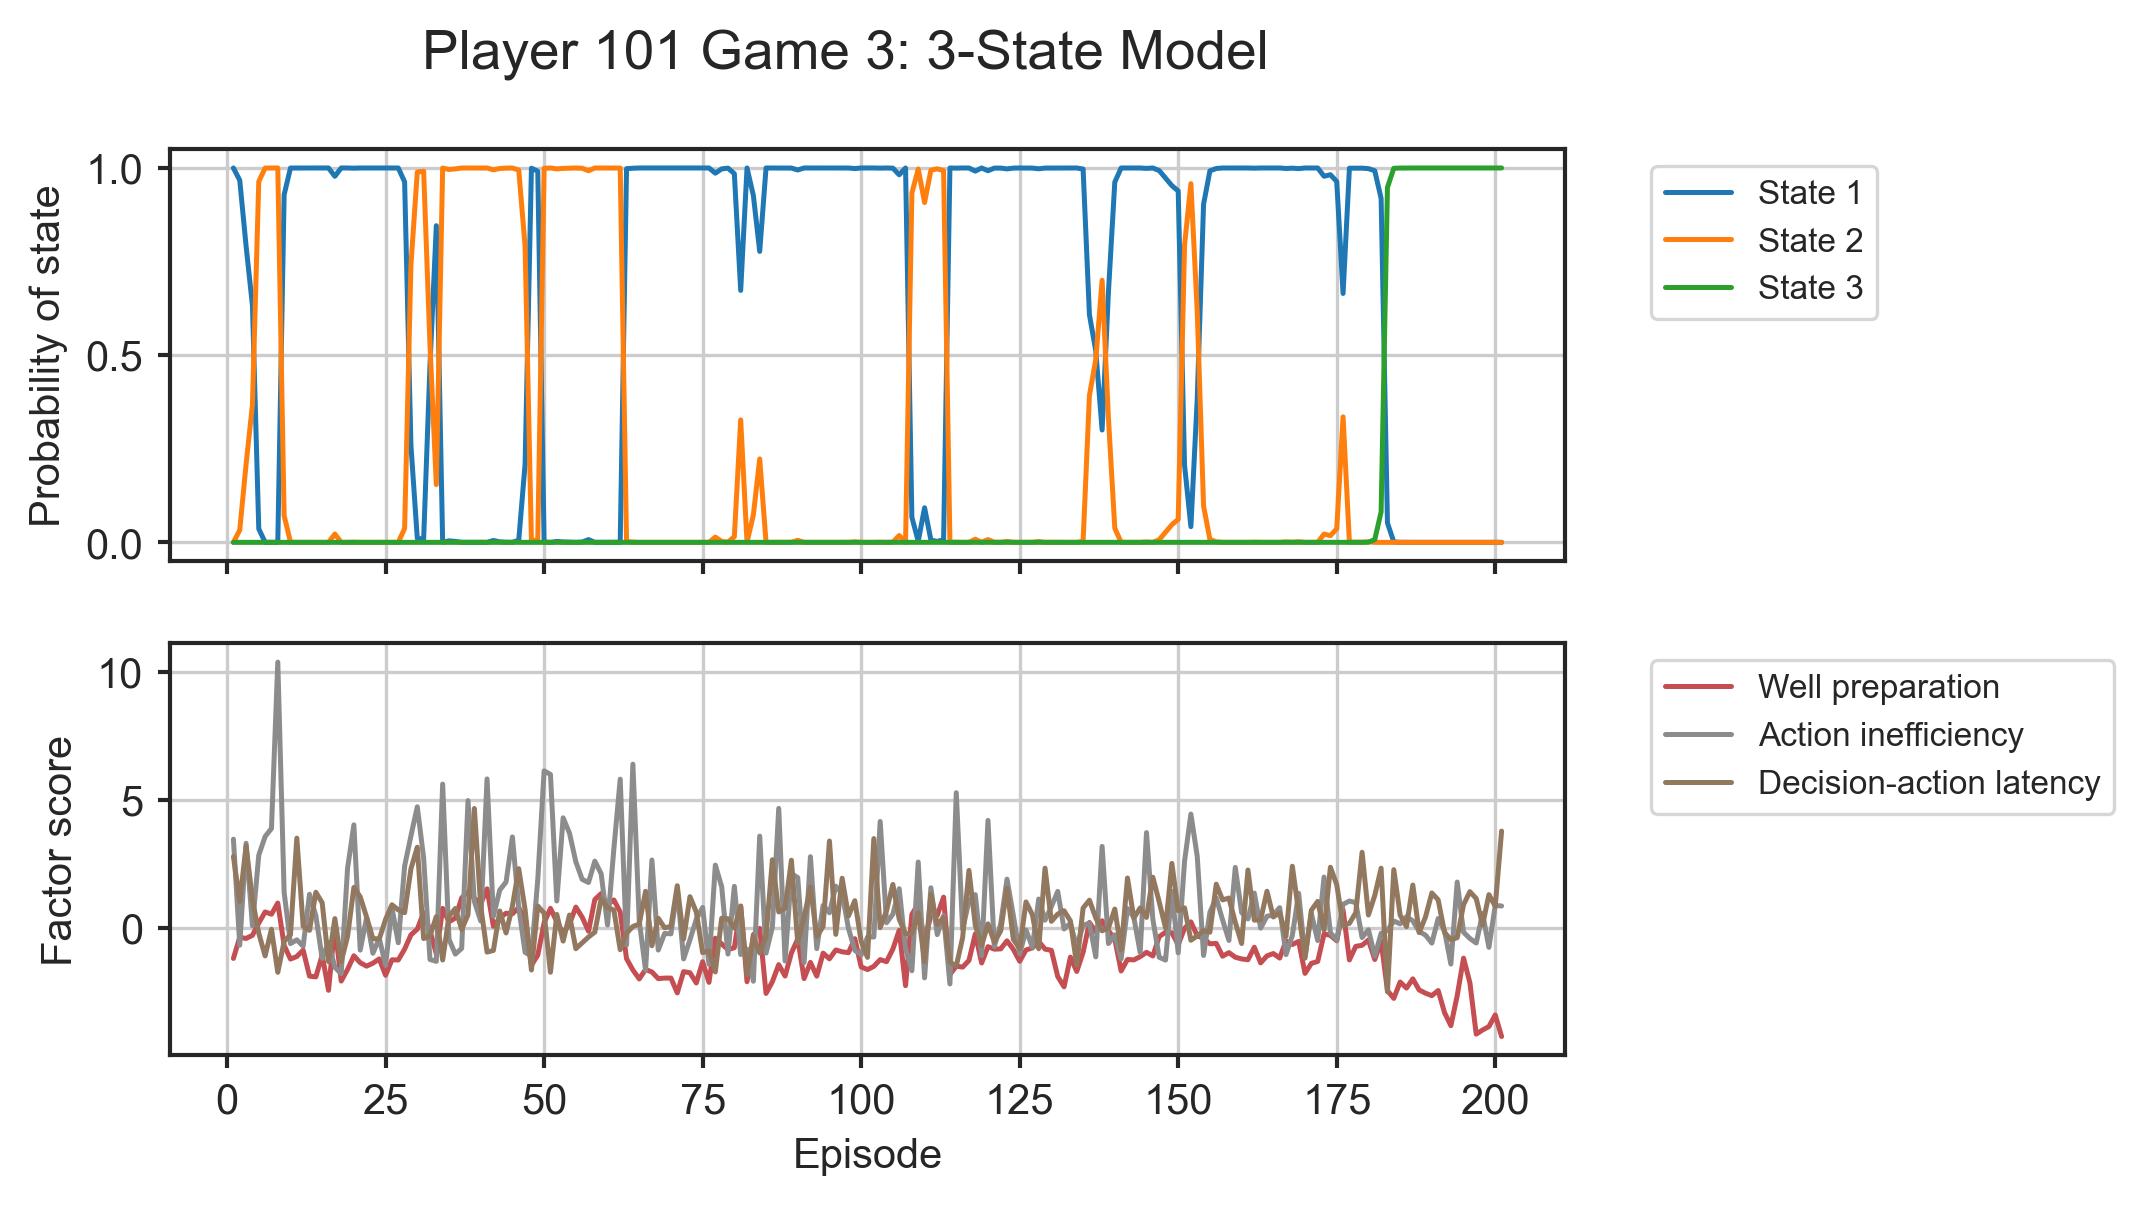

---
MODEL 4: Player 101 Game 4
---
Fitting 3 state model to game 4 of player 101
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.5300   0.0400   0.4200
State 2   0.0000   1.0000   0.0000
State 3   0.3500   0.0000   0.6500 

---------------------------
Component means for each state:
---------------------------

                         State 1  State 2  State 3
Well preparation         -0.6825   5.4801  -0.5884
Action inefficiency      -0.2322   0.5797   3.9123
Decision-action latency   0.0030   0.7429   1.3904 

Log-likelihood of model is -415.99
---
NULL MODEL 4: Player 101 Game 4 (shuffled data)
---
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.4500   0.1000   0.4500
State 2   0.4400   0.2500   0.3100
State 3   0.3500   0.3200   0.3200 

---------------------------
Component means for each state:
-------------------------

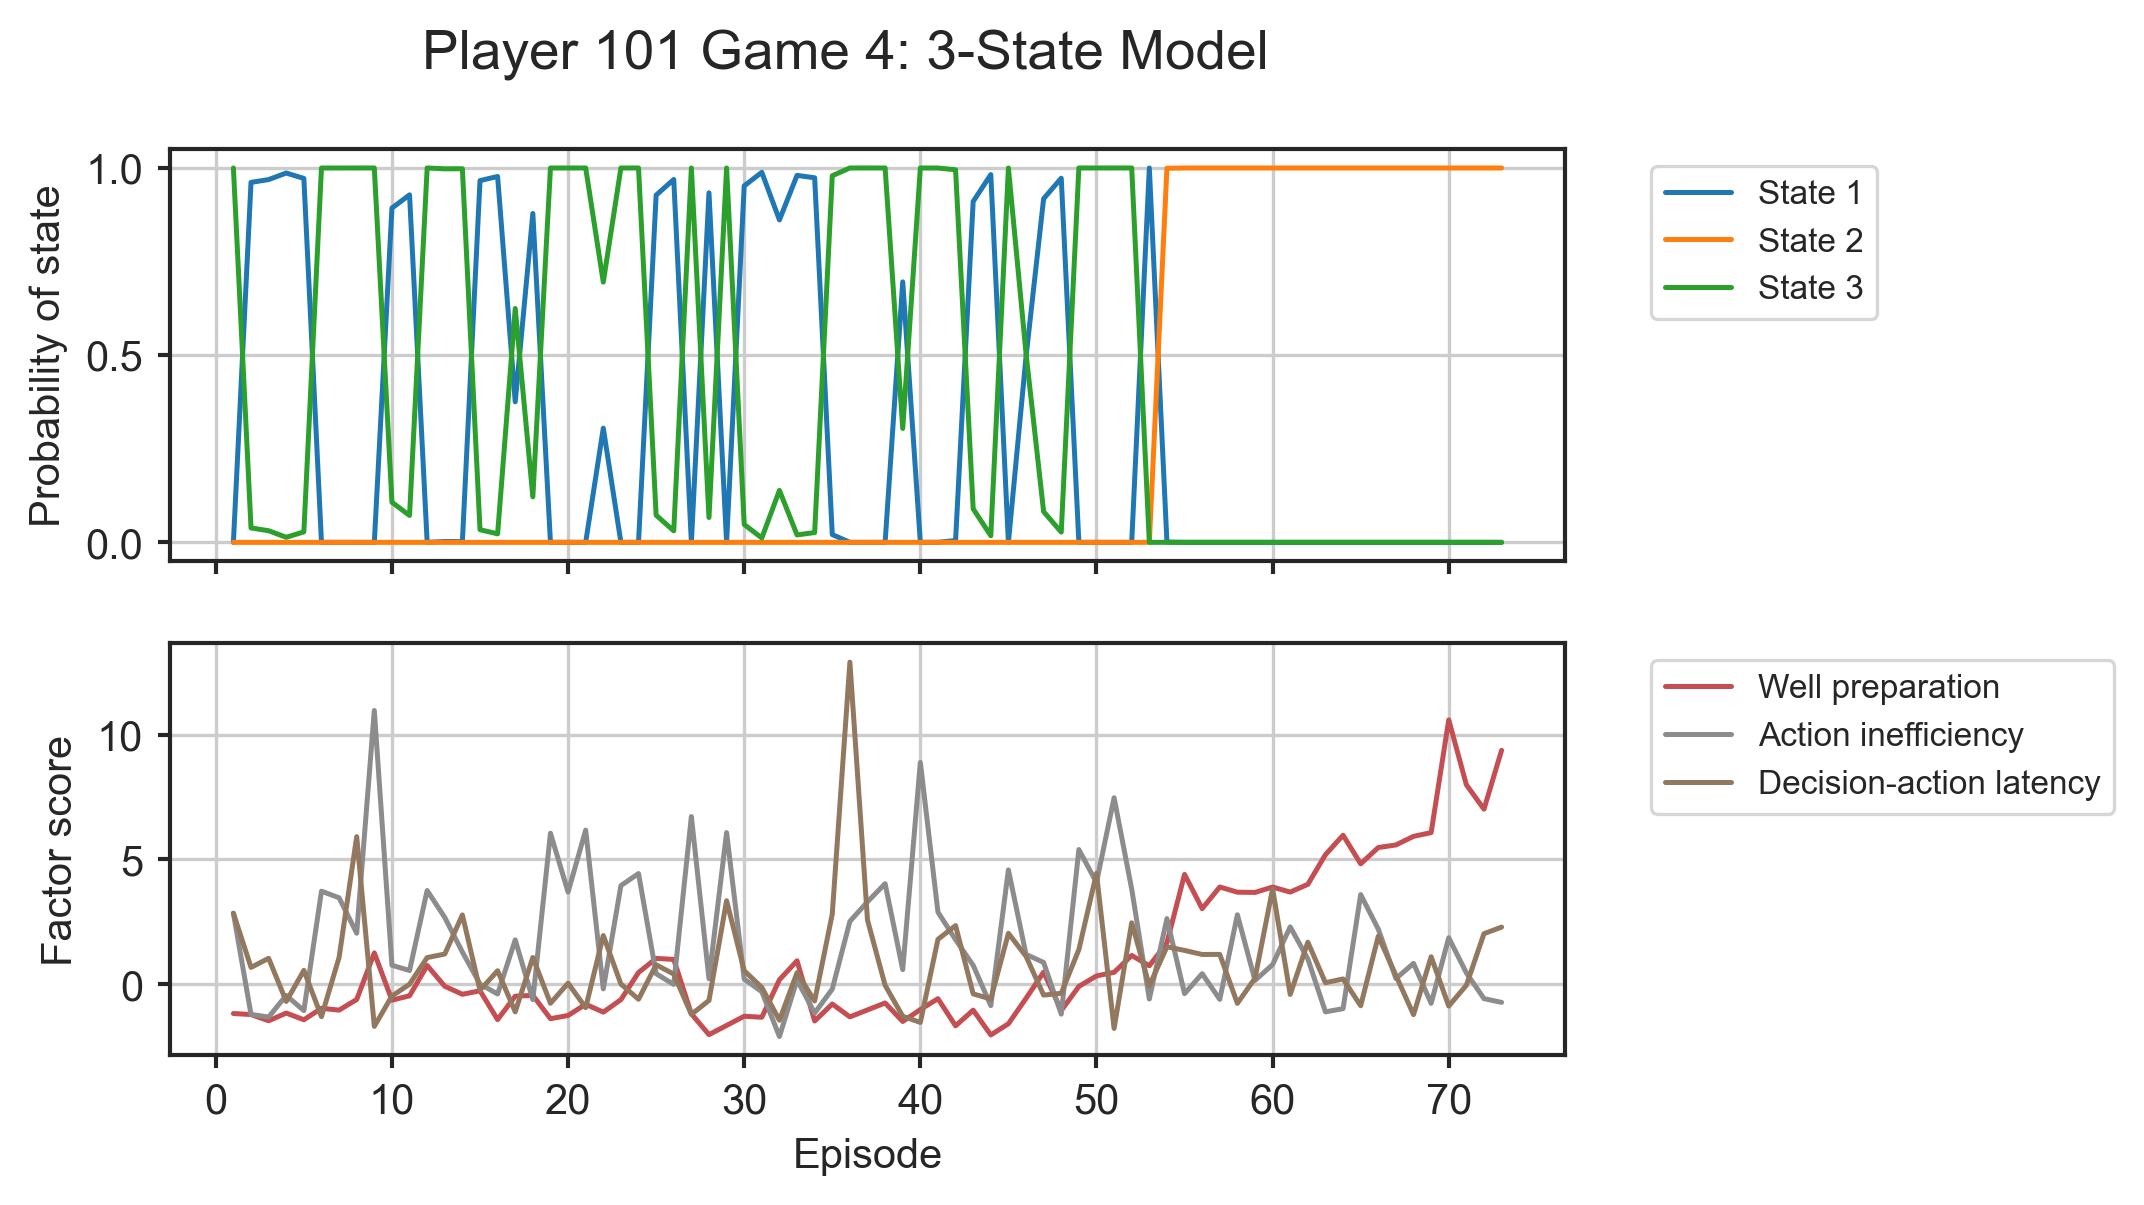

---
MODEL 5: Player 101 Game 5
---
Fitting 3 state model to game 5 of player 101
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.8000   0.0600   0.1400
State 2   0.5600   0.4400   0.0000
State 3   0.6700   0.0900   0.2400 

---------------------------
Component means for each state:
---------------------------

                         State 1  State 2  State 3
Well preparation         -1.0794   0.9551  -0.1638
Action inefficiency       0.2005   1.9880   5.5714
Decision-action latency   0.5544   2.8003  -1.0234 

Log-likelihood of model is -565.93
---
NULL MODEL 5: Player 101 Game 5 (shuffled data)
---
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.1200   0.8300   0.0500
State 2   0.2000   0.7900   0.0100
State 3   0.0000   1.0000   0.0000 

---------------------------
Component means for each state:
-------------------------

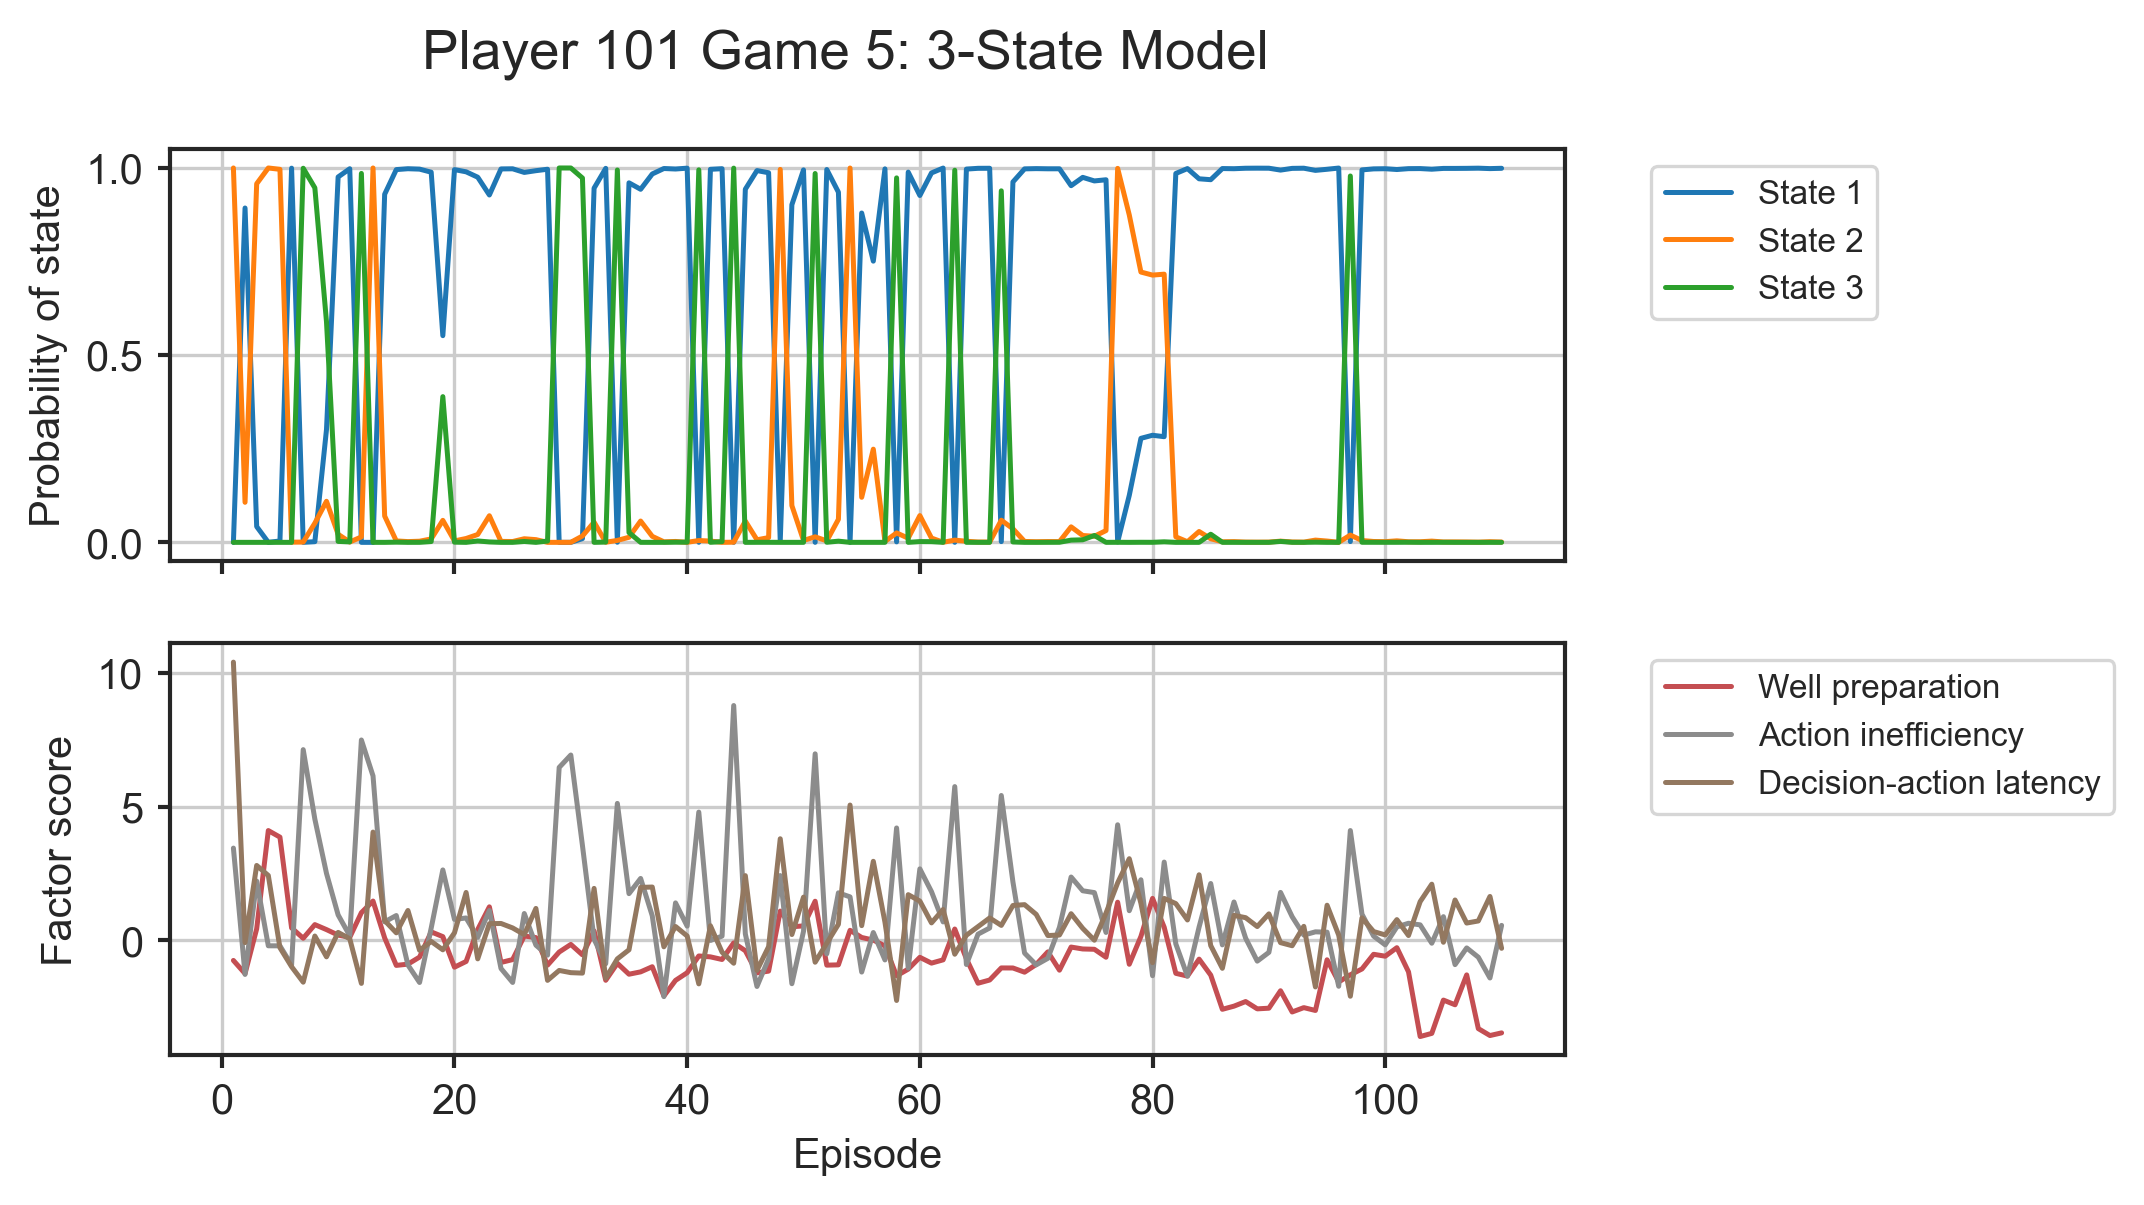

In [41]:
# iterate over subsample
for player in draw:
    for game in range(1, n_games+1):
        for n in n_states:
            print(f'---\nMODEL {counter}: Player {player} Game {game}\n---')
            # fit HMM
            model, post_prob, LL = fit_HMM(df=df,
                                        n_states=n, 
                                        factors=factors, 
                                        factor_labels=factor_labels, 
                                        player_id=player,
                                        nth_game=game,
                                        n_iter=1000,
                                        covar_type='diag')
            models.append(model)
            post_probs.append(post_prob)
            LLs.append(LL)
            # fit HMM after shuffling data in each array - this is our null model for comparison
            print(f'---\nNULL MODEL {counter}: Player {player} Game {game} (shuffled data)\n---')
            null_model, null_prob, null_LL = fit_HMM(df=df,
                            n_states=n, 
                            factors=factors, 
                            factor_labels=factor_labels, 
                            player_id=player,
                            nth_game=game,
                            n_iter=1000,
                            covar_type='diag',
                            null_model=True)
            null_models.append(null_model)
            null_probs.append(null_prob)
            null_LLs.append(null_LL)
            # visualise data
            viz_states(df=df, 
                       n_states=n,
                       factors=factors,
                       factor_labels=factor_labels,
                       post_prob=post_prob,
                       player_id=player, 
                       nth_game=game,
                       fig_dir=fig_dir)
            counter += 1

## Match states across models

- States can switch labels every time a model is fitted to new data - i.e. a state 1 determined principally by action inefficiency might be labelled as state 3 in a different game.
- We attempt to match states here by correlating the vector of component means for each state between models (2 models at a time).
- Two states are "matched" if their correlation is above a specified threshold.
- If each state in model A has one unique match in model B, the matching is successful and we can claim the existence of some unique states co-existing in models A and B.
- If the unique matching is successful between every pair of models for a given player, we can further claim the existence of some unique internal states associated with performance for this player's tetris experience.

In [42]:
n = 3
threshold = 0.8

total = 0
successes = 0 
for index_a, model_a in enumerate(models):
    for index_b, model_b in enumerate(models[index_a+1:]):
        a = model_a.means_
        b = model_b.means_
        corr_mat = cross_corr(n, a, b)
        state_names = [f'State {i+1}' for i in range(n)]
        corr_df = pd.DataFrame(corr_mat)
        corr_df.index = corr_df.columns = state_names
        print('---')
        print(f'Correlating state vectors of models {index_a+1} and {index_a+index_b+2}')
        total += 1
        if check_unique_state_matches(n, corr_df, threshold):
            successes += 1

print(f'\nTotal successful matches = {successes} / {total}')

---
Correlating state vectors of models 1 and 2
**States failed to match**
---
Correlating state vectors of models 1 and 3
**States failed to match**
---
Correlating state vectors of models 1 and 4
**States failed to match**
---
Correlating state vectors of models 1 and 5
**States failed to match**
---
Correlating state vectors of models 2 and 3
**States failed to match**
---
Correlating state vectors of models 2 and 4
States failed to match
---
Correlating state vectors of models 2 and 5
**States failed to match**
---
Correlating state vectors of models 3 and 4
States failed to match
---
Correlating state vectors of models 3 and 5
**States failed to match**
---
Correlating state vectors of models 4 and 5
**States failed to match**

Total successful matches = 0 / 10


Work-in-progress blocks identifying and visualising unique matches between any two given models

In [43]:
print('Model A')
print(tabulate_means(models[1], factors, factor_labels, n), '\n')
print('---')
print('Model B')
print(tabulate_means(models[3], factors, factor_labels, n), '\n')

Model A
                         State 1  State 2  State 3
Well preparation         -1.2595  -0.7321  -3.3284
Action inefficiency      -0.2909   3.3589  -0.1632
Decision-action latency   0.7330   0.5433   1.2131 

---
Model B
                         State 1  State 2  State 3
Well preparation         -0.6825   5.4801  -0.5884
Action inefficiency      -0.2322   0.5797   3.9123
Decision-action latency   0.0030   0.7429   1.3904 



In [44]:
a = models[0].means_
b = models[2].means_

corr_mat = cross_corr(n, a, b)
state_names = [f'State {i+1}' for i in range(n)]
corr_df = pd.DataFrame(corr_mat)
corr_df.index = corr_df.columns = state_names

In [45]:
check_unique_state_matches(n, corr_df, threshold)

**States failed to match**


False

In [46]:
corr_df

,State 1,State 2,State 3
State 1,0.9745,0.5462,0.9373
State 2,0.0331,0.9497,-0.0965
State 3,-0.9874,-0.1917,-0.9996


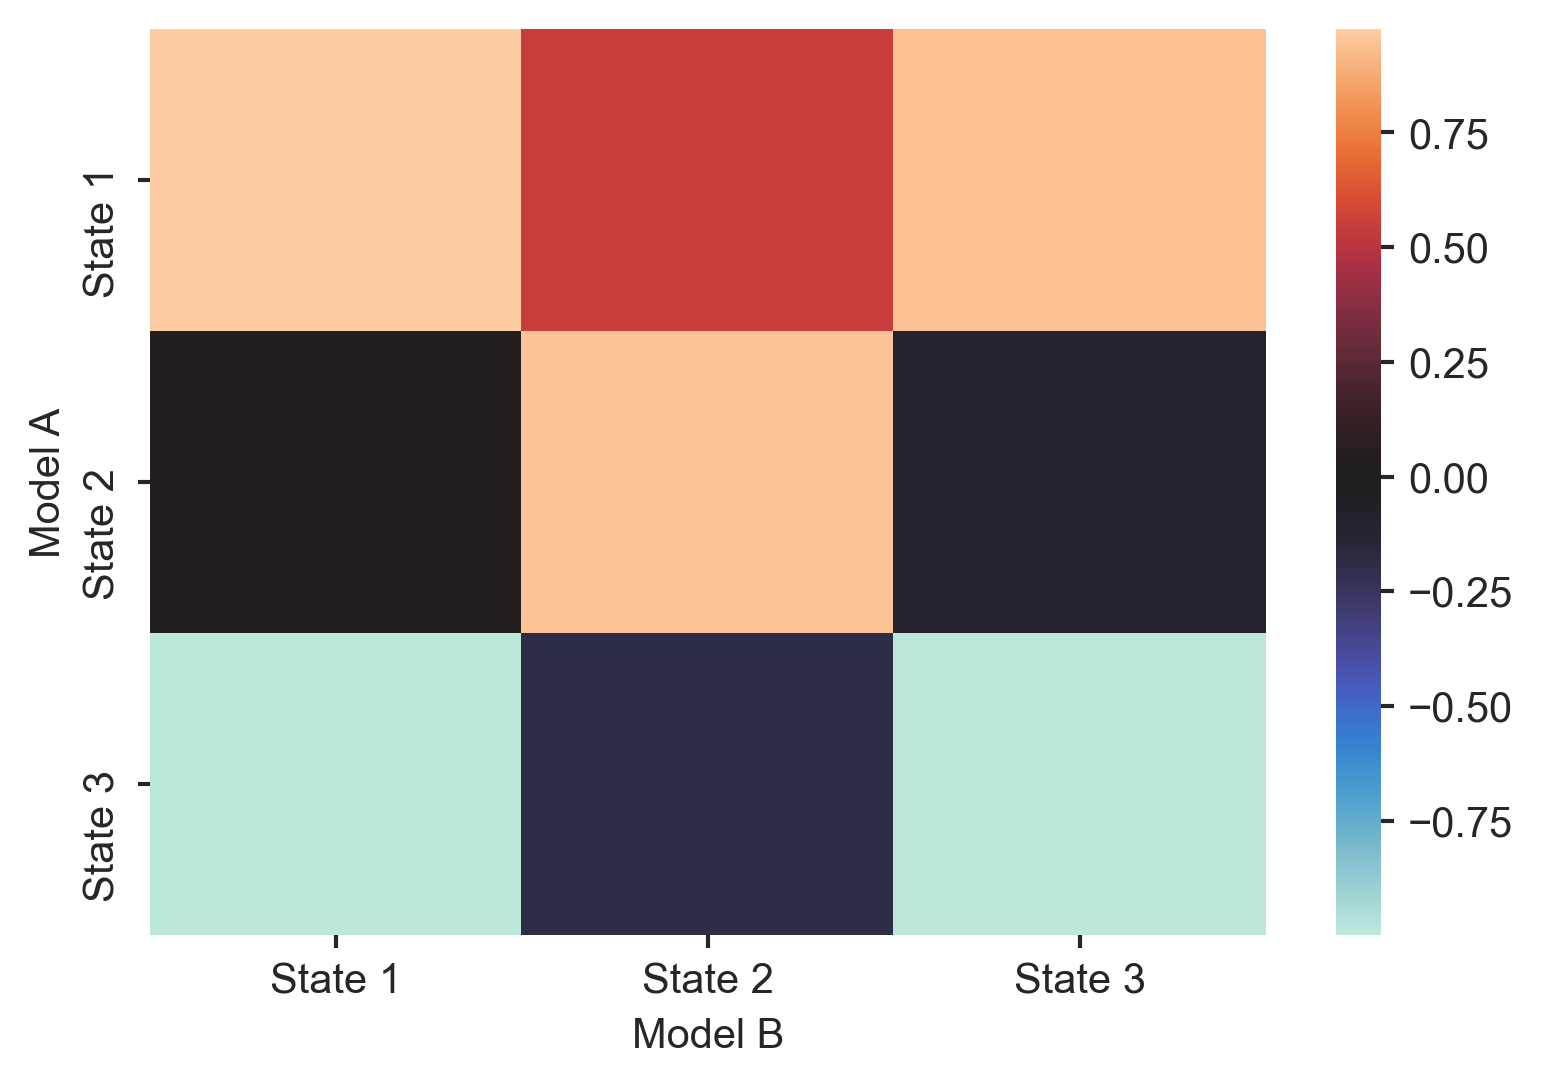

In [47]:
ax = sns.heatmap(corr_df, center=0)
ax.set_ylabel('Model A')
ax.set_xlabel('Model B')

plt.show()